In [14]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
import numpy as np

import matplotlib.pyplot as plt

In [400]:
def data_groups(data, headers):
    chasm_repeats = headers["params"]["detect"]["chasm_repeats"]
    antihole_repeats = headers["params"]["detect"]["antihole_repeats"]
    if "rf_repeats" in headers["params"]["detect"]:
        rf_repeats = headers["params"]["detect"]["rf_repeats"]
    else:
        rf_repeats = 0
    total_detect_repeats = chasm_repeats + antihole_repeats + rf_repeats
    experiment_repeats = headers["params"]["repeats"]

    chasm_avg = []
    antihole_avg = []
    rf_avg = []
    for kk in range(len(data["transmissions_avg"])):
        remainder = kk % total_detect_repeats
        if remainder < chasm_repeats:
            chasm_avg.append(data["transmissions_avg"][kk])
        elif remainder < chasm_repeats + antihole_repeats:
            antihole_avg.append(data["transmissions_avg"][kk])
        else:
            rf_avg.append(data["transmissions_avg"][kk])
    chasm_avg = np.array(chasm_avg)
    antihole_avg = np.array(antihole_avg)
    rf_avg = np.array(rf_avg)
    return (chasm_avg, antihole_avg, rf_avg)

In [434]:
data, headers = get_experiment_data(2963)

In [435]:
chasm_avg, antihole_avg, rf_avg = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

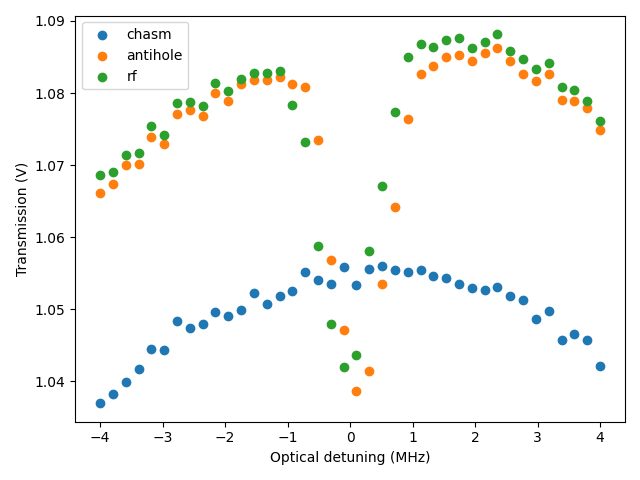

In [436]:
fig, ax = plt.subplots()
ax.scatter(detunings_MHz, np.average(chasm_avg, axis=0), label="chasm")
ax.scatter(detunings_MHz, np.average(antihole_avg, axis=0), label="antihole")
if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, np.average(rf_avg, axis=0), label="rf")
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.legend()
plt.tight_layout()
plt.show()

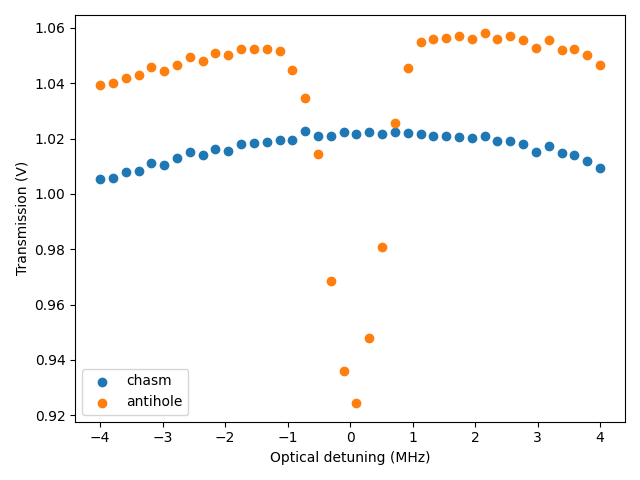

In [424]:
fig, ax = plt.subplots()
ax.scatter(detunings_MHz, np.average(chasm_avg, axis=0), label="chasm")
ax.scatter(detunings_MHz, np.average(antihole_avg, axis=0), label="antihole")
if "rf_repeats" in headers["params"]["detect"]:
    ax.scatter(detunings_MHz, np.average(rf_avg, axis=0), label="rf")
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.legend()
plt.tight_layout()
plt.show()